# What is this?

This is my first attempt to predict the numbers and symbols in a KenKen puzzle. I will be using two methods to analyze the numbers in the KenKen puzzles. The first is with a support vector machine from SKlearn and the second will be with a neural network in Tensor Flow. The neural network may be overkill for this problem but it doesn't hurt to try.

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np 

from scipy import ndimage as ndi

from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from skimage.feature import hog
from skimage.transform import resize
from skimage.measure import find_contours

%matplotlib inline

In [1]:
IMAGE_DIR = 'distorted_from_artificial/'
DIR_LIST = ['0','1','2','3','4','5','6','7','8','9','X','plus','minus','div']
IMAGE_SIZE = 28

Import data

In [3]:
def fetch_data():
    dataset = []
    labels = []
    #i is used for creating the one-hot label by adding 1 to the index in a zeros array
    i = 0
    for folder in DIR_LIST:
        #Read each image from the folder in full_image_dir/
        for image in os.listdir(IMAGE_DIR + folder):
            image_file = os.path.join(IMAGE_DIR, folder, image)
            try:
                image_data = ndi.imread(image_file, mode = 'L')
                image_data = resize(image_data, (IMAGE_SIZE,IMAGE_SIZE))
                #print(image_data.shape)

                assert image_data.shape == (IMAGE_SIZE, IMAGE_SIZE)

                dataset.append(image_data)
                
                label = np.zeros(14)
                label[i] += 1
                
                labels.append(label)
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        
        i += 1
                
    features = np.array(dataset)
    labels = np.array(labels)
    return features, labels

In [4]:
features, labels = fetch_data()

Calculate HOG features:

In [5]:
def hoggify_features(features):
    list_hog_fd = []
    try:
        for feature in features:
            fd = hog(feature.reshape((28, 28)), 
                     orientations=9, 
                     pixels_per_cell=(14, 14), 
                     cells_per_block=(1, 1), 
                     visualise=False)
            list_hog_fd.append(fd)
        hog_features = np.array(list_hog_fd, 'float64')
        return hog_features
    except:
        fd = hog(features, 
                 orientations=9, 
                 pixels_per_cell=(14, 14), 
                 cells_per_block=(1, 1), 
                 visualise=False)
        return np.array(fd)

In [6]:
hog_features = hoggify_features(features)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=4444)

In [8]:
X_train.shape

(4368, 36)

In [9]:
y_train.shape

(4368, 14)

SKlearns SVM doesn't like one-hot format, so convert it back into a labeled format

In [10]:
y_train2 = np.array([list(label).index(1) for label in y_train])

In [11]:
y_test2 = np.array([list(label).index(1) for label in y_test])

Import model

In [12]:
clf = LinearSVC()
clf.fit(X_train, y_train2)
y_pred = clf.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test2, y_pred)
prec = precision_score(y_test2, y_pred, average='weighted')
recall = recall_score(y_test2, y_pred, average='weighted')
f1 = f1_score(y_test2, y_pred, average='weighted')
print('Accuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}'.format(accuracy, prec, recall, f1))

Accuracy: 0.9368131868131868
Precision: 0.9386504721578202
Recall: 0.9368131868131868
F1: 0.9362037303266816


This is not as good as I was hoping but it is possible that blobs are being mispredicted as 'minus' symbols and distorted division symbols are being mispredicted as plus signs. So lets keep going.

Now test on an example image

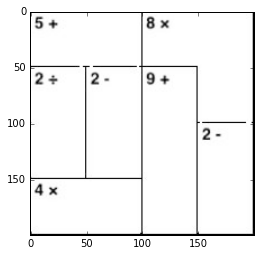

In [14]:
sample4x4_orig = ndi.imread('sample4x4_clean_for_testing.jpg', mode='L')
sample4x4 = resize(sample4x4_orig, (200,200))
plt.imshow(sample4x4, cmap=mpl.cm.Greys_r)

Format of rects is [topleft, topright, bottomright,bottomleft,topleft]

In [15]:
ctrs = find_contours(sample4x4, .85)
rects = [np.array(
        [[min(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]],
         [min(ctr, key=lambda x: x[0])[0],max(ctr, key=lambda x: x[1])[1]],
         [max(ctr, key=lambda x: x[0])[0],max(ctr, key=lambda x: x[1])[1]],
         [max(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]],
         [min(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]]])
          for ctr in ctrs]

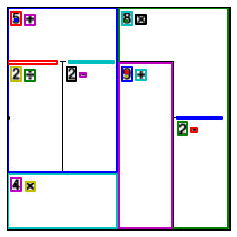

In [16]:
fig, ax = plt.subplots()
ax.imshow(sample4x4[:,:], interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(rects):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [17]:
conversion = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'X', 11:'+',12:'-',13:'/'}

In [18]:
results = []
for rect in rects:
    try:
        pt1 = rect[0][0] #m min
        pt2 = rect[2][0] #m max
        pt3 = rect[0][1] #n min
        pt4 = rect[1][1] #n max
        roi = sample4x4[int(pt1):int(pt2), int(pt3):int(pt4)] 
        roi = resize(roi, (28, 28)) 
        #print(roi)
        roi_hog_fd = hoggify_features(roi)
        #print(roi_hog_fd.shape)
        nbr = clf.predict(roi_hog_fd.reshape(1,-1))[0]
        results.append([pt1,pt2,pt3,pt4,conversion[nbr]])
        
    except:
        pass

In [19]:
results[:5]

[[0.84514170040489922, 148.15239043824701, 0.0, 98.162076271186379, '9'],
 [0.84576612903230386,
  198.14999999999998,
  99.843237704918067,
  197.14999999999995,
  '+'],
 [4.1341059602649093,
  15.950396825396844,
  3.3463541666666332,
  11.881578947368405,
  '5'],
 [4.0503472222222445,
  15.997933884297554,
  102.41193181818171,
  110.95474137931033,
  '6'],
 [6.605555555555588,
  15.726635514018708,
  15.407738095238054,
  24.799382716049355,
  '+']]

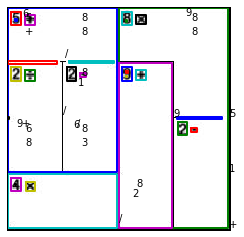

In [20]:
fig, ax = plt.subplots()
ax.imshow(sample4x4[:,:], interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(rects):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

for i in results:
    ax.annotate('{}'.format(i[4]), xy=(i[1], i[3]))

plt.show()


This isn't helpful because of the contour lines picking up the edges and inner circles of numbers (6,8,9)

In [21]:
def binarize(matrix, threshold=0.3):
    temp = deepcopy(matrix)
    for m in range(len(temp)):
        for n in range(len(temp[m])):
            if temp[m][n] < threshold:
                temp[m][n] = 0.0
            else:
                temp[m][n] = 1.0
                
    return temp

2
0
2
0
2
2
2
0
0
0
0
2
2
0
0
0


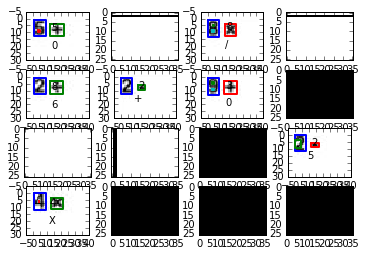

In [22]:
subsquares = [sample4x4[3:29,3:39],
              sample4x4[3:29,53:89],
              sample4x4[3:29,103:139],
              sample4x4[3:29,153:189],
              sample4x4[53:79,3:39],
              sample4x4[53:79,53:89],
              sample4x4[53:79,103:139],
              sample4x4[53:79,153:189],
              sample4x4[103:129,3:39],
              sample4x4[103:129,53:89],
              sample4x4[103:129,103:139],
              sample4x4[103:129,153:189],
              sample4x4[153:179,3:39],
              sample4x4[153:179,53:89],
              sample4x4[153:179,103:139],
              sample4x4[153:179,153:189]
              ]

fig = plt.figure()
i=1
j=1
for square in subsquares:
    results = []
    
    ctrs = find_contours(square, .85)
    rects = [np.array(
            [[min(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]],
             [min(ctr, key=lambda x: x[0])[0],max(ctr, key=lambda x: x[1])[1]],
             [max(ctr, key=lambda x: x[0])[0],max(ctr, key=lambda x: x[1])[1]],
             [max(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]],
             [min(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]]])
              for ctr in ctrs]
    
    for rect in rects:
        try:
            pt1 = rect[0][0] #m min
            pt2 = rect[2][0] #m max
            pt3 = rect[0][1] #n min
            pt4 = rect[1][1] #n max
            roi = square[int(pt1):int(pt2)+1, int(pt3):int(pt4)+1] 
            roi = resize(roi, (28, 28)) 
            
            
            '''plt.subplot(5,5,j)
            plt.imshow(roi, interpolation='nearest', cmap=plt.cm.gray)           

            j += 1'''
            
            #print(roi)
            roi_hog_fd = hoggify_features(roi)
            #print(roi_hog_fd.shape)
            nbr = clf.predict(roi_hog_fd.reshape(1,-1))[0]
            results.append([pt1,pt2,pt3,pt4,conversion[nbr]])
            
        except:
            pass
        
    #filter out a result contained in another result:
    for result in results:
        temp = [res for res in results if res != result]
        for other in temp:
            if result[0] >= other[0] and result[1] <= other[1] and\
            result[2] >= other[2] and result[3] <= other[3]:
                results.remove(result)

    #Plot all of the subplots
    plt.subplot(4,4,i)
    plt.imshow(square, interpolation='nearest', cmap=plt.cm.gray)

    for contour in rects:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

    for res in results:
        plt.annotate('{}'.format(res[4]), xy=(res[1], res[3]))            

    i += 1
    
    print(len(results))
           
                
plt.show()

It doesn't seem to be working well. I think the problem is that the histogram or oriented gradients for my self created data isn't representative of the true data. I will now attempt a neural network

## Tensor Flow

In [23]:
import tensorflow as tf

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=4444)

In [25]:
X_train = np.array([i.reshape(-1) for i in X_train])
X_test = np.array([i.reshape(-1) for i in X_test])

In [26]:
X_train.shape

(4368, 784)

In [27]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 14])

W = tf.Variable(tf.zeros([784,14]))
b = tf.Variable(tf.zeros([14]))


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 14])
b_fc2 = bias_variable([14])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.initialize_all_variables())

#training set has 4368 units which divides evenly into 42 and 104
for i in range(104):
    batch_x = X_train[i*42:(i+1)*42]
    batch_y = y_train[i*42:(i+1)*42]
    if i%20 == 0 or i%103==0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch_x, y_: batch_y, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch_x, y_: batch_y, keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: X_test, y_: y_test, keep_prob: 1.0}))

#sess = tf.Session()
#sess.run(init)

step 0, training accuracy 0.0952381
step 20, training accuracy 0.285714
step 40, training accuracy 0.666667
step 60, training accuracy 0.880952
step 80, training accuracy 0.880952
step 100, training accuracy 0.904762
step 103, training accuracy 0.928571
test accuracy 0.89652


### Remarks on this modeling attempt

Well that's discouraging. The test accuracy ended up being even lower for the NN than with the SVM. If you noticed, I used the regular, non-HOG features. This is because when I used the HOG features, my model was unable to learn from it and the accuracy floated at < 0.10. I'm going to have to obtain a new dataset.